# 0.0 - IMPORTS

In [1]:
import math
import numpy as np
import pandas as pd
import inflection
import datetime

import seaborn as sns

from matplotlib import pyplot as plt

from IPython.core.display import HTML
from IPython.display import Image

## 0.1 Helper Functions

## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how ='left', on ='Store' )

In [4]:
df_raw.sample(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
89851,652,2,2015-05-12,5401,588,1,0,0,0,a,a,20390.0,NaN,NaN,0,NaN,NaN,NaN
733332,448,4,2013-09-12,8771,809,1,1,0,0,a,c,3970.0,9.0,2009.0,0,NaN,NaN,NaN


# 1.0 - Passo 01 - DESCRIÇÃO DOS DADOS

## Data fields
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.
Note that all schools are closed on public holidays and weekends.
a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating,
1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew

E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [5]:
df1 = df_raw.copy() #copio o DataFrame para esse bloco

## 1.1 Rename Columns

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
               'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

new_columns = list(map(snakecase, old_columns))

#rename
df1.columns = new_columns

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [9]:
#Qual a qtd de linhas e colunas do dataset
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
#A coluna date era object e vamos mudá-la para formato de data
df1['date'] = pd.to_datetime(df1['date'])

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

### Os NA precisam ser tratados.
#### 1) Jogar essas linhas fora -> VTG: rápido e fácil | DVG: jogar dado fora, pode prejudicar a performance do modelo
#### 2) Usando métodos de ML para substituir as linhas NA pelo comportamento da coluna (mediana, média, previsões)
#### 3) Entendendo o negócio. Pq esse NA está aqui?

#### Vamos tratar pelo método 3 cada coluna com NA. 
#### competition_distance
#### competition_open_since_month    
#### competition_open_since_year
#### promo2_since_week               
#### promo2_since_year               
#### promo_interval                  

In [14]:
#------------------------------------------------------------------------------------
#competition_distance
#------------------------------------------------------------------------------------
#se tem NA é porque não tem competidor próximo (assumption) => usar o método isnan da classe math
#esse método vai me dizer se nesa linha da coluna competition_distance o valor é NA.
#vamos substituir o valor onde for NA por um valor muito grande!!!

#encontrando o valor máximo de competition_distance 75860.0
#df1['competition_distance'].max()

#Logo vamos admitir um valor bem alto 200000.0 para as linhas com valor NA, substituindo df1 por x
#para aplicar essa função em todas as linhas, usar o método apply
#Terei que especificar em qual coluna será aplicada a função, posso retirar do interior o ['competition_distance']
#O resultado dessa função quero sobreescrever os resultados originais
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

In [15]:
#------------------------------------------------------------------------------------
#competition_open_since_month & competition_open_since_year
#------------------------------------------------------------------------------------
#se tem NA é porque ou não tem competidor ou esqueceram de lançar o mês de que ele chegou
#colocar o mês da venda como mês do competidor (assumption) => usar o método isnan da classe math
#primeiro ver se ela é NA, com o método isnan, e fazer uma condição
#se isso for vdd vou extrair o mês da coluna date e colocar nela
#se não for vdd eu retorno o valor (depois do else)
#chamando a função lambda eu posso substituir o df1
#axis=1 pois tenho mais de uma coluna e preciso explicitar que a ação será em cada linha ao longo das colunas
#quero que o resultado sobreescreva a coluna original competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)


#mesmo raciocício para competition_open_since_year, porém extraindo o ano
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


#mesmo raciocício para promo2_since_week, porém extraindo a semana
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


#mesmo raciocício para promo2_since_year, porém extraindo o ano
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)



In [16]:
#------------------------------------------------------------------------------------
#promo_interval
#------------------------------------------------------------------------------------
#Criar uma coluna auxiliar para trabalhar os dados
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'Mai', 6:'Jun',
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)


df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0
                                                             else 1 if x['month_map'] in x['promo_interval'].split(',')
                                                             else 0, axis = 1)


In [17]:
df1.sample(5).T

,145348,611756,777315,28714,819328
store,399,407,946,840,589
day_of_week,1,1,7,1,4
date,2015-03-23 00:00:00,2013-12-30 00:00:00,2013-08-04 00:00:00,2015-07-06 00:00:00,2013-06-27 00:00:00
sales,5586,4869,0,7210,3604
customers,585,427,0,1091,415
open,1,1,0,1,1
promo,0,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,1,0,0,0
store_type,a,a,a,a,a


## 1.6 Check Types

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [21]:
#Alterar os float para int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [22]:
#Checar as alterações
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [23]:
#Checar se ainda tem algum NA
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [24]:
#Qual a qtd de linhas e colunas do dataset
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 20


## 1.7 Statistical Descriptive

In [ ]:
#Entender o negócio
#Conseguir detectar erros -> Métricas de dispersão (desvio padrão, variância, mín, máx, range, skew e kurtosis)
#e de tendência central (médias e medianas)
#skew: como que a deformação da minha distribuição em relação a normal
#kurtose: fala sobre a concentração dos dados

In [25]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [26]:
#Central Tendency (mean, median)
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion (std, min, max, var, skew, kurtosis)
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'media', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,media,mediana,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


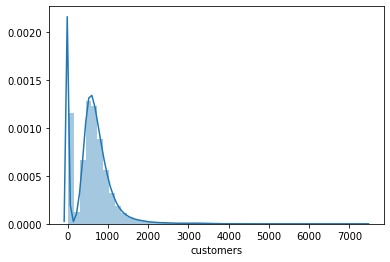

In [27]:
sns.distplot(df1['customers'])

### 1.7.2 Categorical Attributes

In [28]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

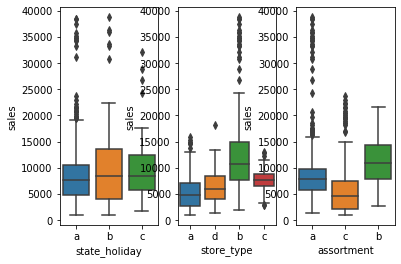

In [29]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday' , y='sales' , data=aux1 )

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type' , y='sales' , data=aux1 )

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment' , y='sales' , data=aux1 )

# 2.0 - Passo 02 - FEATURE ENGINEERING

In [30]:
#copiar os dados para seção 2.0
df2 = df1.copy()

## 2.1 Mapa mental das hipóteses

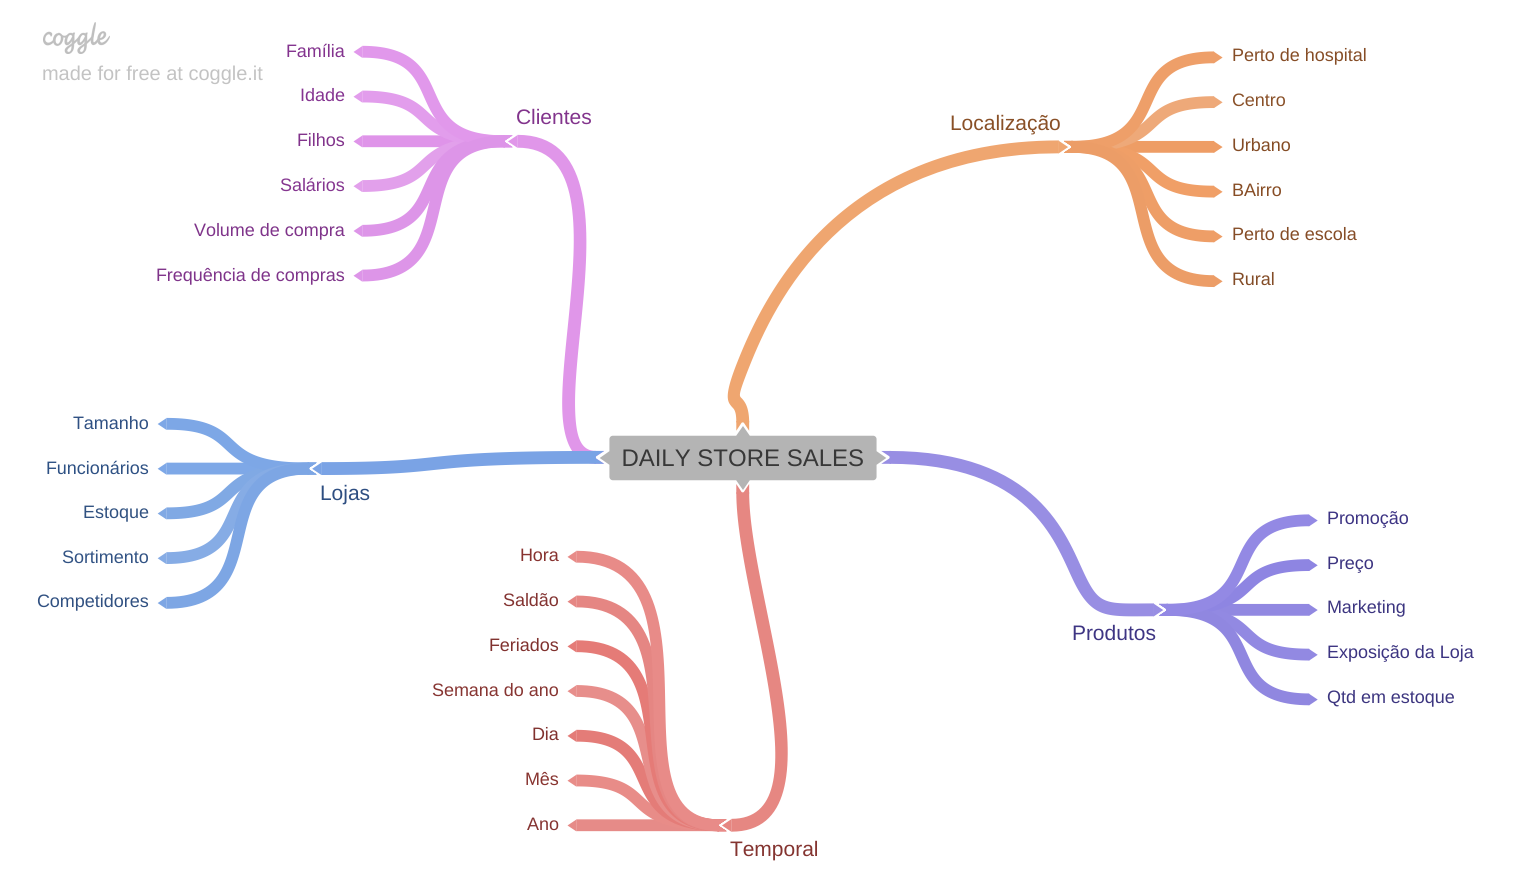

In [31]:
Image('img/Mind-Maps-Hipotesis.png')

## 2.2 Hypotesis Creation

Blá blá blá + [APOSTA] + {ATRIBUTO DO MIND MAP} + **deveriam** + {VARIÁVEL RESPOSTA QUE SERÁ MODELADA} + [APOSTA]

### 2.1.1 Hipóteses das Lojas

**1.** Lojas com MAIOR quadro de **funcionários** deveriam **vender** MAIS.

**2.** Lojas com MAIOR **estoque** deveriam **vender** MAIS.

**3.** Lojas com MAIOR **porte** deveriam **vender** MAIS.

**4.** Lojas com MENOR **porte** deveriam **vender** MENOS.

**5.** Lojas com MAIOR **sortimento** deveriam **vender** MAIS.

### 2.1.2 Hipóteses Produto

**1.** Lojas com MAIOR investimento em **marketing** deveriam **vender** MAIS.

**2.** Lojas com MAIOR **exposição** deveriam **vender** MAIS.

**3.** Lojas com MENOR **preço** deveriam **vender** MAIS.

**4.** Lojas com MAIOR **promoção** deveriam **vender** MAIS.

### 2.1.3 Hipóteses Tempo (Sazonalidade)

**1.** Lojas com MAIOR número de **feriado** deveriam **vender** MENOS.

**2.** Lojas NOS PRIMEIROS 06 **meses** deveriam **vender** MAIS.

**3.** Lojas que ABREM MAIS **dias** deveriam **vender** MAIS.

São apostas, não relação de causa e efeito mas sim encontrar a correlação (se houver) entre os atributos e a minha variável resposta, que será modelada...

## 2.3 Lista Final de Hipóteses

### As hipóteses que comporão essa lista serão priorizadas  e separadas com base nas informação que já exstentem, que permitam verificar a "APOSTA" feita....

**1.** Lojas com MAIOR **sortimentos** deveriam **vender** MAIS.

**2.** Lojas com **competidores** MAIS PRÓXIMOS deveriam **vender** MAIS.

**3.** Lojas com **competidores** À MAIS TEMPO deveriam **vender** MAIS.

**4.** Lojas com **promoção** À MAIS TEMPO deveriam **vender** MAIS.

**5.** Lojas com MAIS dias de **promoção** deveriam **vender** MAIS.

**6.** Lojas com MAIS **promoção** consecutiva deveriam **vender** MAIS.

**7.** Lojas ABERTAS **feriado de Natal** deveriam **vender** MAIS.

**8.** Lojas AO LONGO do **ano** deveriam **vender** MAIS.

**9.** Lojas no SEGUNDO **semestre** deveriam **vender** MAIS.

**10.** Lojas DEPOIS DO DÉCIMO **dia** deveriam **vender** MAIS.

**11.** Lojas ABERTAS no **final de semana** deveriam **vender** MENOS.

**12.** Lojas ABERTAS no **feriado escolar** deveriam **vender** MENOS.

## 2.4 Feature Engineering 

In [32]:
#Derivação da coluna date:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week_year
df2['week_year'] = df2['date'].dt.weekofyear

#year_week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
#promo since

#assortment
#state_holiday

In [33]:
df2.sample(5).T #Vê as colunas year, month, day, week_year e year_week

,139538,623509,681378,262559,188668
store,164,1010,899,1115,234
day_of_week,6,5,2,4,4
date,2015-03-28 00:00:00,2013-12-20 00:00:00,2013-10-29 00:00:00,2014-12-04 00:00:00,2015-02-12 00:00:00
sales,4126,14823,4458,9775,8866
customers,444,1267,565,574,941
open,1,1,1,1,1
promo,0,1,0,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,1,0,0
store_type,a,d,d,d,d


In [34]:
#competition since
#Preciso unir duas colunas para formar a data competition since e depois iterar com a date.
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)
#promo since

#assortment
#state_holiday

In [35]:
df2.sample(5).T #Vê as colunas competiton since e a coluna competition time month

,613050,381182,205382,697949,622032
store,586,971,223,745,648
day_of_week,7,3,3,1,6
date,2013-12-29 00:00:00,2014-07-30 00:00:00,2015-01-28 00:00:00,2013-10-14 00:00:00,2013-12-21 00:00:00
sales,0,9501,7633,5636,8931
customers,0,989,750,635,762
open,0,1,1,1,1
promo,0,1,1,0,0
state_holiday,0,0,0,0,0
school_holiday,0,1,0,0,0
store_type,a,c,d,a,d


In [36]:
#promo since
#Também precisarei unir informações de duas colunas, porém a dificuldade é que as informações são week e year
#1) Fazer o join dessas informações para ter uma única data
#Faz o join dos caracteres e depois transforma em data
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)
#assortment
#state_holiday

In [37]:
df2.sample(5).T

,172469,985836,963305,948276,555749
store,760,962,731,197,150
day_of_week,5,2,1,7,2
date,2015-02-27 00:00:00,2013-01-29 00:00:00,2013-02-18 00:00:00,2013-03-03 00:00:00,2014-02-18 00:00:00
sales,7359,4785,15866,0,8145
customers,1122,785,1375,0,767
open,1,1,1,0,1
promo,0,0,1,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,c,a,c,c


In [38]:
#assortment -> describes an assortment level: a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

In [39]:
df2.sample(5).T

,483053,755118,829791,206372,990213
store,1044,1049,1017,98,879
day_of_week,5,6,2,2,5
date,2014-04-25 00:00:00,2013-08-24 00:00:00,2013-06-18 00:00:00,2015-01-27 00:00:00,2013-01-25 00:00:00
sales,4640,2750,8780,5455,3460
customers,730,464,1167,458,346
open,1,1,1,1,1
promo,0,0,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,0,0,0,0
store_type,c,a,c,d,d


In [40]:
#state_holiday -> a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular day')


In [41]:
df2.sample(5).T

,476540,886420,501921,122271,90190
store,106,781,957,737,991
day_of_week,3,7,2,1,2
date,2014-04-30 00:00:00,2013-04-28 00:00:00,2014-04-08 00:00:00,2015-04-13 00:00:00,2015-05-12 00:00:00
sales,11306,0,6688,9869,4935
customers,1051,0,807,1213,498
open,1,0,1,1,1
promo,1,0,0,1,0
state_holiday,regular day,regular day,regular day,regular day,regular day
school_holiday,0,0,0,0,0
store_type,a,a,d,a,a


# 3.0 - Passo 03 - FILTRAGEM DE VARIÁVEIS

In [42]:
df3 = df2.copy()

In [43]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular day,regular day,regular day,regular day,regular day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.1 Filtragem das Linhas

### Quero excluir as linhas onde a loja está fechada e as vendas sejam igual a zero

In [44]:
# open != 0
# sales > 0
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [45]:
#coluna customers: quantos clientes tinham naquela loja nesse dia que fizeram essas compras.
#Não tenho quantos terão daqui a seis semanas. Teria que fazer um projeto a parte.
#Restrição de negócio, não tenho ela no momento da predição
#devo retirar as colunas open, por só ter agora valores igual a 1;
#e as colunas que eu já derivei seus valores: promo_interval e month_map
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [46]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')